In [6]:
import sqlite3
from IPython.display import HTML, display

db = 'file:results.db?mode=ro'
con = sqlite3.connect(db, uri=True)

cur = con.cursor()
cur.execute("SELECT * FROM runs WHERE description LIKE '%scaling%'")

def display_result(cur, data=cur.fetchall()):
    html = "<table>"
    headers = list(map(lambda x: x[0], cur.description))
    
    html += "<thead><tr>" + "".join(["<td>" + h + "</td>" for h in headers]) + "</tr></thead>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td>%s</td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))
display_result(cur)

id,date,hostname,revision,cluster_size,description,flags
21,2021-12-14 14:38:53,i10pc138,caae9e9ec5aac44a8b29bab1d8911f246c244264,256,strong scaling,
22,2021-12-14 14:44:51,i10pc138,caae9e9ec5aac44a8b29bab1d8911f246c244264,256,weak scaling,
41,2022-01-10 08:44:23,i10pc138,1deabd72b7f7d5fe4eaeef7383eb91da073478d1,256,strong scaling,


## Strong scaling

In [7]:
benchmark_id = 41

<IPython.core.display.Javascript object>


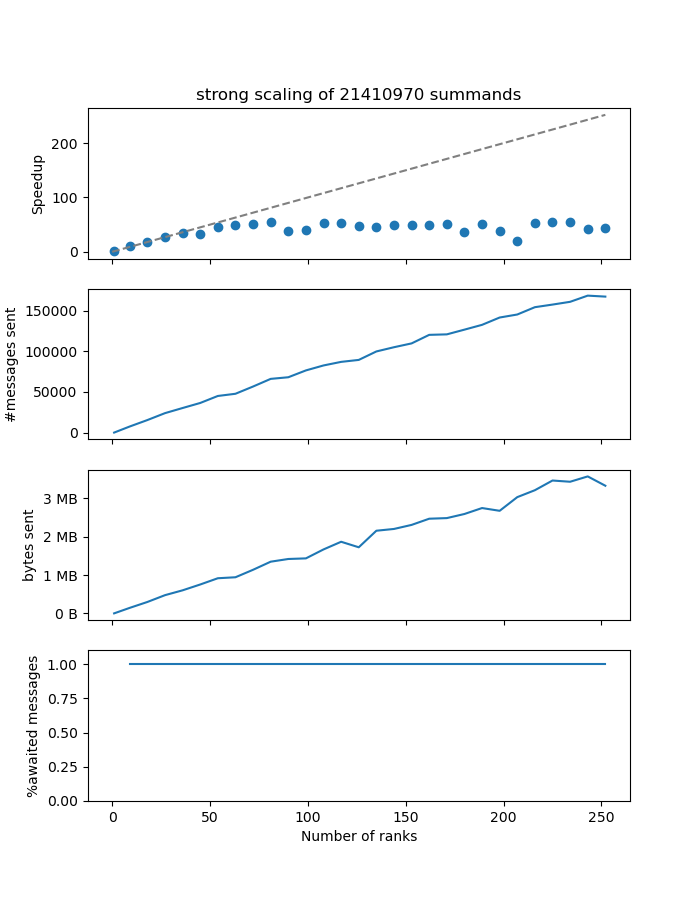

In [32]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter

cur.execute("SELECT description FROM runs WHERE id = ?", (benchmark_id,))
description = cur.fetchone()[0]

weak_scaling = (description == "weak scaling")

f = plt.figure(figsize=(7,9))
axs = f.subplots(4, sharex=True)
axs[-1].set_xlabel("Number of ranks")
axs[0].set_ylabel(("Scaled " if weak_scaling else "") + "Speedup")

cur.execute("SELECT time_ns, n_summands FROM results WHERE run_id=? AND ranks = 1", (benchmark_id,))
r = cur.fetchone()
sequential_time = r[0] * 1e-9

axs[0].set_title(f"{description} of {r[1]} summands")

cur.execute("""
SELECT ranks, time_ns, messages_sent, messages_awaited, bytes_sent 
FROM results 
LEFT JOIN messages ON id=messages.result_id
WHERE run_id = ? AND ranks > 1
ORDER BY ranks;
""", (benchmark_id,))


X = [1] # core count
Y = [1] # speed-up
MSG_SENT = [0] # messages sent
MSG_WAIT = [0] # messages awaited
BYTES_SENT = [0] # bytes sent


for row in cur.fetchall():
    ranks, time_ns, messages_sent, messages_awaited, bytes_sent = row
    X.append(ranks)
    parallel_time = time_ns * 1e-9
    speedup = sequential_time / parallel_time
    if weak_scaling:
        speedup *= ranks
    Y.append(speedup)
    MSG_SENT.append(messages_sent)
    MSG_WAIT.append(messages_awaited)
    BYTES_SENT.append(bytes_sent)

axs[0].scatter(X, Y)
axs[0].plot([0,max(X)], [0,max(X)], "--", color='gray')

axs[1].set_ylabel("#messages sent")
axs[1].plot(X, MSG_SENT)

axs[2].set_ylabel("bytes sent")
axs[2].plot(X, BYTES_SENT)
axs[2].yaxis.set_major_formatter(EngFormatter("B"))

axs[3].set_ylim(0.0, 1.1)
axs[3].set_ylabel("%awaited messages")
percentage = np.array(MSG_WAIT[1:]) / np.array(MSG_SENT[1:])
axs[3].plot(X[1:], percentage)

plt.savefig("weak_scaling_256.svg")
plt.show()